# 주택 가격 예측: 회귀(regression) 문제
*주의: 회귀와 로지스틱 회귀(logistic regression)은 다른 개념이다. 로지스틱 회귀는 회귀가 아닌, 분류 알고리즘이다.*

## Input
* 1970년 중반 보스턴 외곽 지역의 범죄율, 지방세율 등
* 총 506개의 데이터 포인트
  * 404개의 훈련 샘플
  * 102개의 테스트 샘플
* 입력 데이터에 있는 각 feature는 서로 다른 scale을 가진다
  * 0 ~ 1, 1 ~ 12, 1~100

## Output
* 주택 가격의 중간 가격 (단위: 천 달러)


In [1]:
from keras.datasets import boston_housing

(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

Using TensorFlow backend.


57344/57026 [==============================] - 0s 3us/step


In [2]:
print(train_data.shape)
print(test_data.shape)

print(train_targets)

(404, 13)
(102, 13)
[15.2 42.3 50.  21.1 17.7 18.5 11.3 15.6 15.6 14.4 12.1 17.9 23.1 19.9
 15.7  8.8 50.  22.5 24.1 27.5 10.9 30.8 32.9 24.  18.5 13.3 22.9 34.7
 16.6 17.5 22.3 16.1 14.9 23.1 34.9 25.  13.9 13.1 20.4 20.  15.2 24.7
 22.2 16.7 12.7 15.6 18.4 21.  30.1 15.1 18.7  9.6 31.5 24.8 19.1 22.
 14.5 11.  32.  29.4 20.3 24.4 14.6 19.5 14.1 14.3 15.6 10.5  6.3 19.3
 19.3 13.4 36.4 17.8 13.5 16.5  8.3 14.3 16.  13.4 28.6 43.5 20.2 22.
 23.  20.7 12.5 48.5 14.6 13.4 23.7 50.  21.7 39.8 38.7 22.2 34.9 22.5
 31.1 28.7 46.  41.7 21.  26.6 15.  24.4 13.3 21.2 11.7 21.7 19.4 50.
 22.8 19.7 24.7 36.2 14.2 18.9 18.3 20.6 24.6 18.2  8.7 44.  10.4 13.2
 21.2 37.  30.7 22.9 20.  19.3 31.7 32.  23.1 18.8 10.9 50.  19.6  5.
 14.4 19.8 13.8 19.6 23.9 24.5 25.  19.9 17.2 24.6 13.5 26.6 21.4 11.9
 22.6 19.6  8.5 23.7 23.1 22.4 20.5 23.6 18.4 35.2 23.1 27.9 20.6 23.7
 28.  13.6 27.1 23.6 20.6 18.2 21.7 17.1  8.4 25.3 13.8 22.2 18.4 20.7
 31.6 30.5 20.3  8.8 19.2 19.4 23.1 23.  14.8 48.8 22.6 33.4 

In [0]:
### 데이터 정규화 : 특성의 중앙을 0으로, 표준 편차는 1로 맞춤


mean = train_data.mean(axis=0)
std = train_data.std(axis=0)

# 훈련 데이터 정규화
train_data -= mean
train_data /= std

# 테스트 데이터 정규화
# 이 때에도 훈련 데이터로 계산한 mean과 std 값을 사용해야 한다.
# 머신 러닝 작업 과정에서는, 절대로 테스트 데이터에서 계산한 어떤 값도 사용해서는 안 된다.
test_data -=mean
test_data /= std

In [0]:
### 모델 정의하기 : 64개의 유닛을 가진 2개의 은닉 층

# 훈련 데이터의 개수가 작아 과대적합이 더 쉽게 일어나므로, 이를 피하기 위해 작은 모델을 사용할 수 있다.

from keras import models
from keras import layers

def build_model():
  model = models.Sequential()
  model.add(layers.Dense(64, activation='relu', input_shape=(train_data.shape[1],)))
  model.add(layers.Dense(64, activation='relu'))
  # 마지막 층 : 하나의 유닛, 활성화 함수는 없다. (전형적인 스칼라 회귀를 위한 구성) 
  # => 네트워크가 어떤 범위의 값이라도 예측하도록 자유롭게 학습된다.
  model.add(layers.Dense(1))  
  # loss=mse : mean squared error, 평균 제곱 오차. 예측과 타깃 거리 사이의 제곱. 회귀 문제에서 널리 사용되는 손실함수이다.
  # metrics=['mae'] : mean absolute error, 평균 절대 오차를 모니터링. 예측과 타깃 거리 사이의 절대값.
  model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
  return model

In [5]:
### K-겹 검증을 사용한 훈련 검증

# 데이터 포인트의 수가 많지 않기 때문에, 검증 세트와 훈련 세트로 어떤 데이터 포인트가 선택되었는지에 따라 검증 점수가 크게 달라진다. (검증 세트의 분할에 대한 검증 점수의 분산이 높다.)
# 신뢰 있는 모델 평가를 위해, K-겹 교차 검증(K-fold cross-validation)을 사용한다.
# 데이터를 K개의 분할(폴드)로 나누고, K개의 모델을 만든다. K-1개의 분할에서 훈련을 진행하고, 나머지 1개의 분할에서는 평가한다.
# 모델의 검증 점수는 K개 검증 점수의 평균으로 구한다.

import numpy as np

k = 4
num_val_samples = int(len(train_data) / k)
num_epochs = 100
all_scores = []

for i in range(k):
  print('처리중인 폴드 #', i)
  val_data = train_data[(i * num_val_samples): ((i + 1) * num_val_samples)]
  val_targets = train_targets[i * num_val_samples : (i + 1) * num_val_samples]
  partial_train_data = np.concatenate( [train_data[: i * num_val_samples], train_data[(i + 1) * num_val_samples : ]], axis=0 )
  partial_train_targets = np.concatenate( [train_targets[ : i * num_val_samples], train_targets[(i + 1) * num_val_samples : ]] , axis=0)
  
  model = build_model() 
  model.fit(partial_train_data, partial_train_targets, epochs=num_epochs, batch_size=1, verbose=0)
  val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
  all_scores.append(val_mae)

처리중인 폴드 # 0






처리중인 폴드 # 1
처리중인 폴드 # 2
처리중인 폴드 # 3


In [6]:
print(all_scores)
print(np.mean(all_scores))

[2.001354996520694, 2.4250550954648764, 2.8337371727027514, 2.445438346060196]
2.4263964026871294


In [7]:
# 각 폴드에서 검증 점수를 로그에 저장하기

num_epochs = 500
all_mae_histories = []

for i in range(k):
  print('처리중인 폴드 #', i)
  val_data = train_data[i * num_val_samples : (i+1) * num_val_samples]
  val_targets = train_targets[i * num_val_samples : (i+1) * num_val_samples]
  partial_train_data = np.concatenate( [train_data[: i * num_val_samples], train_data[(i+1) * num_val_samples : ]], axis=0 )
  partial_train_targets = np.concatenate( [train_targets[ : i * num_val_samples], train_targets[(i + 1) * num_val_samples : ]] , axis=0)
  
  model = build_model()
  history = model.fit(partial_train_data, partial_train_targets, validation_data=(val_data, val_targets), epochs=num_epochs, batch_size=1, verbose=0)
  mae_history = history.history['val_mean_absolute_error']
  all_mae_histories.append(mae_history)

처리중인 폴드 # 0
처리중인 폴드 # 1
처리중인 폴드 # 2
처리중인 폴드 # 3


In [0]:
average_mae_history = [ np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs) ]

In [14]:
print(len(mae_history))
print(len(all_mae_histories))
print(len(average_mae_history))

500
4
500


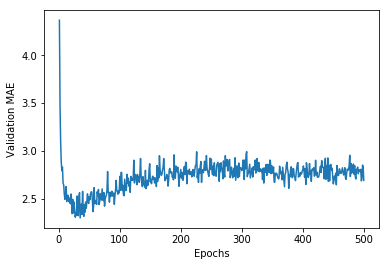

In [10]:
import matplotlib.pyplot as plt

plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

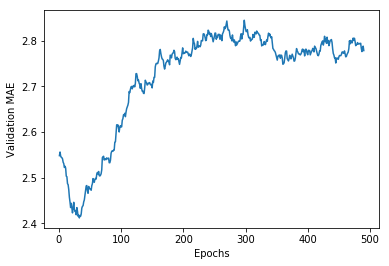

In [15]:
# 처음 10개의 데이터 포인트를 제외한 검증 점수 그리기

def smooth_curve(points, factor=0.9):
  # 부드러운 곡선을 얻기 위해, 각 포인트를 이전 포인트의 지수 이동 평균(exponential moving average)으로 대체
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

smooth_mae_history = smooth_curve(average_mae_history[10:])

plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

In [16]:
# 분석한 정보를 바탕으로 매개변수를 튜닝해 최종 모델 훈련하기

model = build_model()
model.fit(train_data, train_targets, epochs=80, batch_size=16, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

102/102 [==============================] - 0s 963us/step


In [17]:
test_mae_score

2.8829500534955192